In [1]:
import os
import pickle
from collections import defaultdict
import json

from umap import UMAP
from scipy.ndimage import maximum_filter, gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2

from utils.list_files import list_files, get_stem
from utils.histogram_equalize import histogram_equalize
from utils.ffmpeg import auread
from utils.imutil import imshow, imresize

from siren import build_fingerprint, build_features, build_targets, to_indices

sr = 44100 # original files are actually 48kHz
hop_length = 512
feature_framerate = sr / hop_length

In [84]:
from matplotlib.cm import rainbow, inferno

def normalize(e):
    o = e.copy()
    o -= o.min(0)
    o /= o.max()
    return o

def save_npy_float(fn, data):
    np.save(fn, data.astype(np.float32))
    
def save_npy_int(fn, data):
    np.save(fn, data.astype(np.int32))
    
def get_coloring(indices, func=rainbow):
    return func(indices / (indices.max() + 1))[:,:3]

In [52]:
def load_cache(name):
    with open(f'cache/{name}.pkl', 'rb') as f:
        return pickle.load(f)
    
grouped = load_cache('grouped')

for stem in grouped:
    grouped[stem]['index'] = np.arange(len(grouped[stem]['stems']))

In [53]:
# ungroup into list of lists
ungrouped = defaultdict(list)
for stem, group in grouped.items():
    for k,v in group.items():
        ungrouped[k].append(v)
        
def stack(arr):
    # hstack 1 dimensional
    if len(np.shape(arr[0])) == 1:
        return np.hstack(arr)
    # vstack two+ dimensional
    return np.vstack(arr)

# stack and convert to flat arrays
ungrouped = {k:stack(v) for k,v in ungrouped.items()}    

In [145]:
unit_indices = to_indices(ungrouped['units'])

In [187]:
# this can be done better by using the annotations directly
unit_position = np.zeros_like(unit_indices)
previous = None
last_change = None
for i,e in enumerate(unit_indices):
    if e != previous:
        last_change = i
    previous = e
    unit_position[i] = i - last_change
    
save_npy_int('export/features_unit_position.npy', unit_position)

In [6]:
%%time
full_umap = UMAP().fit_transform(ungrouped['amp'], unit_indices)

1
CPU times: user 33min 33s, sys: 9min 52s, total: 43min 25s
Wall time: 17min 20s


In [7]:
fg=unit_indices>-1
bg=unit_indices==-1

In [197]:
%%time
fg_umap = UMAP().fit_transform(ungrouped['amp'][fg], unit_indices[fg])

CPU times: user 2min 57s, sys: 19.7 s, total: 3min 17s
Wall time: 34 s


In [201]:
full_umap[fg] = fg_umap

In [199]:
# plt.figure(figsize=(12,12))
# plt.scatter(*fg_umap_no_init.T, lw=0, s=1, alpha=0.25, cmap='hsv', c=unit_indices[fg])
# plt.show()

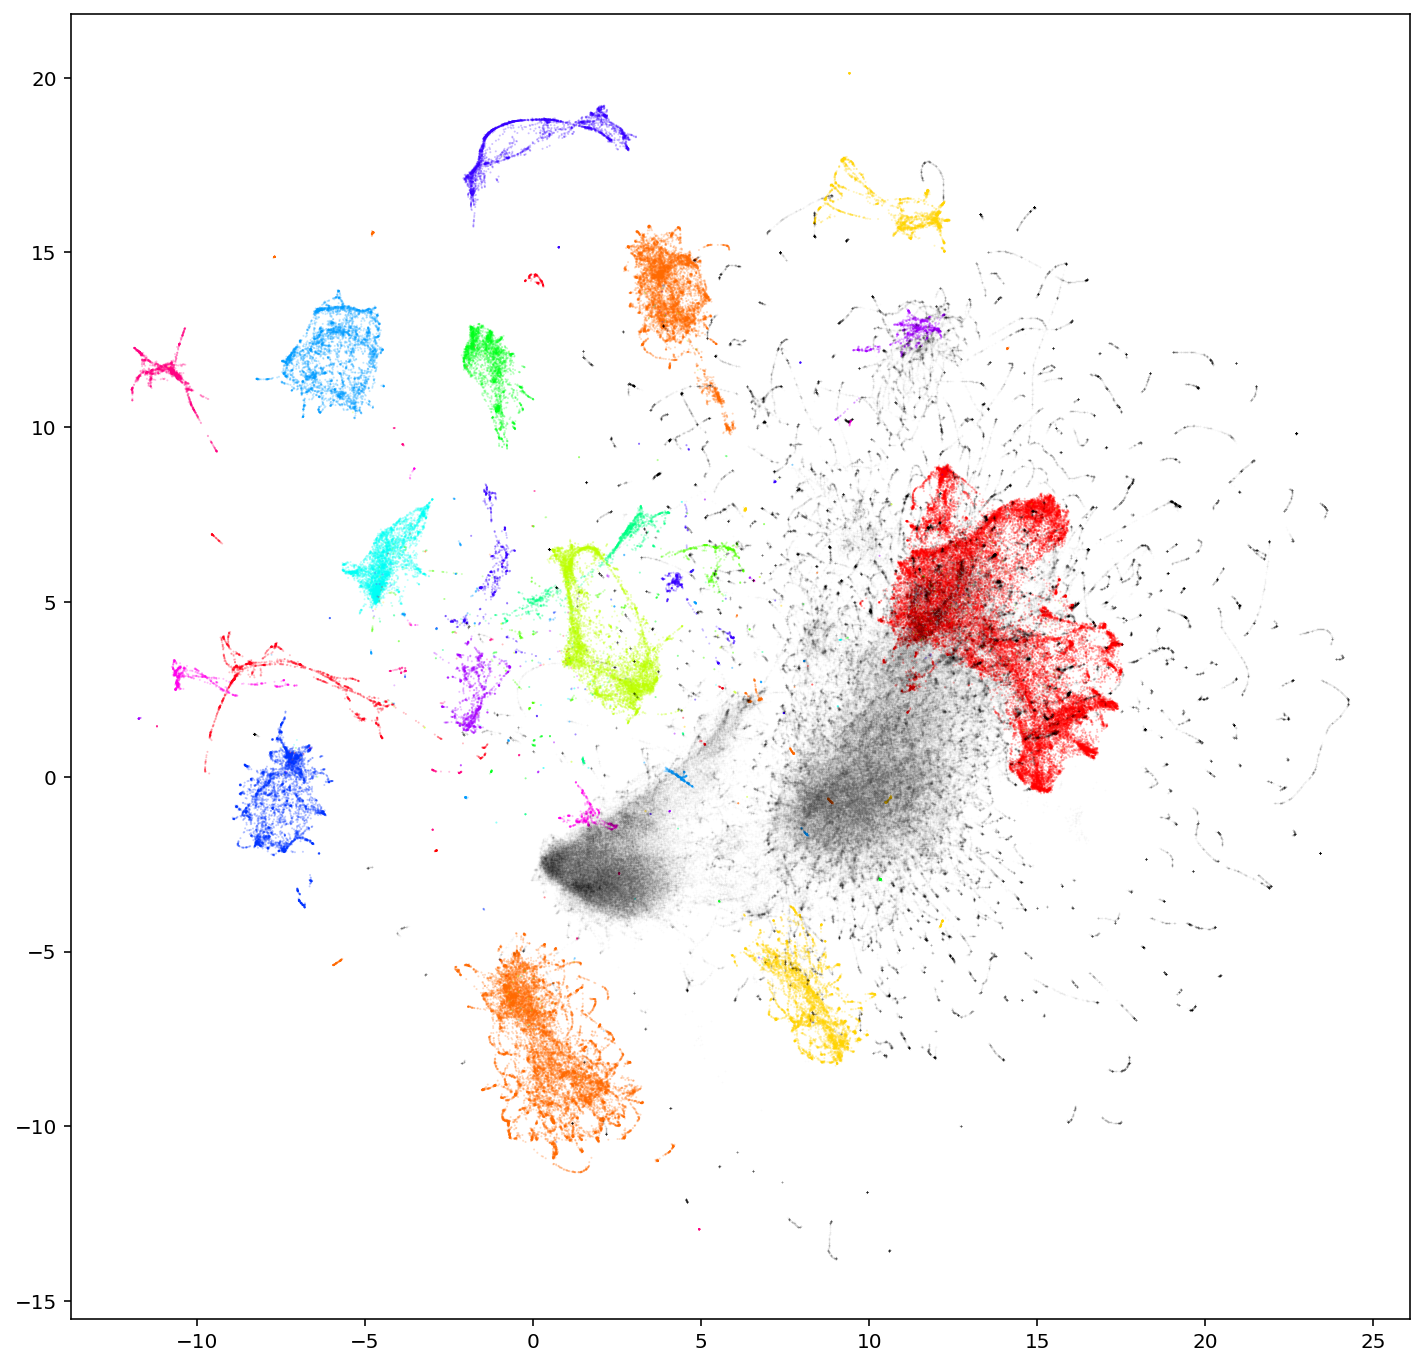

In [202]:
plt.figure(figsize=(12,12))
plt.scatter(*full_umap[fg].T, lw=0, s=1, alpha=0.25, cmap='hsv', c=unit_indices[fg])
plt.scatter(*full_umap[bg].T, lw=0, s=1, alpha=0.02, c='k')
# plt.scatter(*partial_umap[0].T, lw=0, s=1, alpha=0.25, cmap='hsv', c=unit_indices)
plt.show()

In [164]:
import json
with open('data/ableton_analysis.json') as f:
    ableton = json.load(f)

In [165]:
end_time = max([e['end'] for e in ableton])
max_index = int(end_time * feature_framerate)
timed = np.zeros((max_index), np.int32)
timed_unannotated = np.zeros((max_index), np.int32)

for embed_index, (stem, stem_index, annotated) in enumerate(zip(ungrouped['stems'], ungrouped['index'], ungrouped['annotated'])):
    stem_index_time = stem_index / feature_framerate
    for track in ableton:
        if track['stem'] != stem:
            continue
        track_duration = track['end'] - track['start'] # precompute this
        if stem_index_time < track['loop_start'] or stem_index_time > (track_duration + track['loop_start']):
            continue
        output_index = int((track['start'] - track['loop_start']) * feature_framerate) + stem_index
        if output_index >= len(timed):
            continue
        if annotated:
            timed[output_index] = embed_index
        else:
            timed_unannotated[output_index] = embed_index

In [166]:
missing_indices = timed == 0
timed[missing_indices] = timed_unannotated[missing_indices]

In [167]:
# plt.plot(ungrouped['annotated'])
# plt.plot(ungrouped['stems'])
# plt.plot(ungrouped['units'])
# plt.show()

# plt.plot([ungrouped['rms'][i] for i in timed])
# plt.show()

In [203]:
save_npy_int('export/timed.npy', timed)
save_npy_int('export/features_unit_indices.npy', unit_indices)
save_npy_float('export/features_local_rms.npy', ungrouped['local_rms'].reshape(-1,1))
save_npy_float('export/features_rms.npy', ungrouped['rms'].reshape(-1,1))
save_npy_float('export/features_amp.npy', ungrouped['amp'])
save_npy('export/embed_2d_features_by_unit.npy', normalize(full_umap))
save_npy('export/color_features_by_unit.npy', get_coloring(unit_indices))

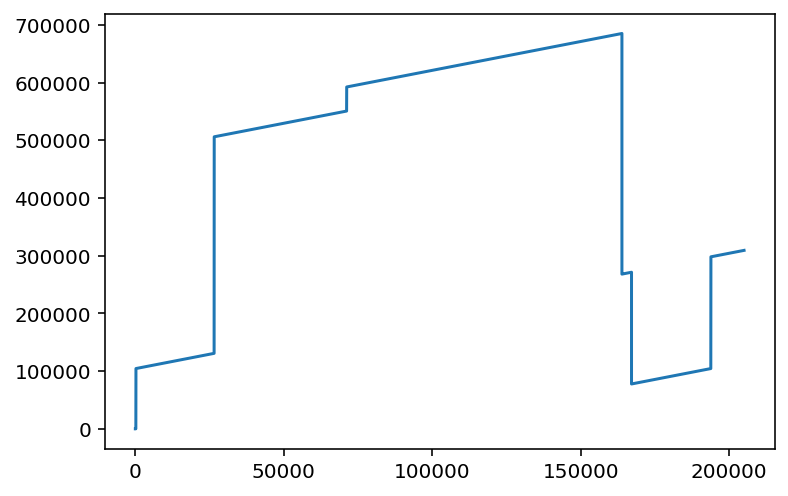

In [169]:
plt.plot(timed)

In [61]:
partial_amp.shape, unit_indices[:iw:k].shape

((64, 64), (10705,))

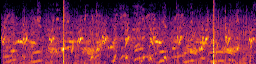

0:2.97 @ 44100Hz, 256 frames x 64 bins @ 512 hop_length


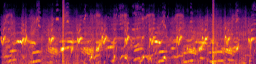

0:2.97 @ 44100Hz, 256 frames x 64 bins @ 512 hop_length


In [54]:
from utils.specshow import specshow
# ungrouped['amp'].max()
sub = ungrouped['amp'][:4096]
k = 16
sub_resize = imresize(sub, output_wh=(64,4096//k))
specshow(np.flipud(sub[::k].T), gamma=1, zoom=5)
specshow(np.flipud(sub_resize.T), gamma=1, zoom=5)

In [25]:
ungrouped['amp'][:1024]

(685121, 64)